In [2]:
from ovito.io import import_file
from ovito.modifiers import (
    CreateBondsModifier,
    BondAnalysisModifier,
    CoordinationAnalysisModifier,
)
from ovito.vis import Viewport, PythonViewportOverlay
from ovito.vis import ViewportOverlayInterface
from ovito.vis import TachyonRenderer, OSPRayRenderer, OpenGLRenderer
from PySide6.QtGui import QImage, QPainter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [4]:
pipeline = import_file("dump.nacl-melt")
pipeline.add_to_scene()

In [5]:
def plot_bond_angle_distribution(data):
    plt.figure(figsize=(5 / 2, 3.5 / 2))
    plt.bar(data[:, 0], data[:, 1], width=data[1, 0] - data[0, 0], align="center")
    plt.xlabel("Bond angle (degrees)", fontsize=8)
    plt.ylabel("Count", fontsize=8)
    ax = plt.gca()
    ax.tick_params(axis="both", which="major", labelsize=6, direction="in")
    ax.set_ylim(0.0, 300)
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    plt.tight_layout()
    plt.savefig("bond_angle_plot.png", dpi=300, transparent=True)
    plt.close()


def plot_radial_distribution_function(data):
    plt.figure(figsize=(5 / 2, 3.5 / 2))
    plt.plot(data[:, 0], data[:, 1])
    plt.xlabel("Distance", fontsize=8)
    plt.ylabel("g(r)", fontsize=8)
    ax = plt.gca()
    ax.tick_params(axis="both", which="major", labelsize=6, direction="in")
    ax.set_xlim(0.0, None)
    ax.set_ylim(0.0, 5.0)
    plt.tight_layout()
    plt.savefig("rdf_plot.png", dpi=300, transparent=True)
    plt.close()

In [6]:
class Overlay(ViewportOverlayInterface):
    def render(self, canvas, **kwargs):
        frame = kwargs["frame"]
        data = pipeline.compute(frame=frame)
        plot_radial_distribution_function(data.tables["coordination-rdf"].xy())
        plot_bond_angle_distribution(data.tables["bond-angle-distr"].xy())
        with canvas.qt_painter() as painter:
            bond_angle_image = QImage("bond_angle_plot.png")
            rdf_image = QImage("rdf_plot.png")
            # Define the position and size of the images on the canvas
            bond_angle_pos = (1.0, 1.0)  # right-top corner
            rdf_pos = (1.0, 0.0)  # right-bottom corner
            size = (0.45, 0.45)  # fractional coordinates
            canvas.draw_image(
                bond_angle_image, pos=bond_angle_pos, size=size, anchor="north east"
            )
            canvas.draw_image(rdf_image, pos=rdf_pos, size=size, anchor="south east")

In [7]:
# Create bonds if not already in the dump
pipeline.modifiers.append(CreateBondsModifier(cutoff=3.5))

# Calculate the bond-angle distribution
bond_angle_modifier = BondAnalysisModifier()
pipeline.modifiers.append(bond_angle_modifier)

# Calculate the radial distribution function
rdf_modifier = CoordinationAnalysisModifier(cutoff=6.5, number_of_bins=100)
pipeline.modifiers.append(rdf_modifier)

In [8]:
viewport = Viewport(type=Viewport.Type.Ortho, camera_dir=(2, 1, -1))
viewport.zoom_all()
viewport.camera_pos = [15, -1, 15]

overlay = PythonViewportOverlay(delegate=Overlay())
viewport.overlays.append(overlay)

pipeline.add_to_scene()

In [9]:
from IPython.display import Image

In [10]:
# Render image
frame = 9
fstatic = f"nacl_melt_rendered_frame_{frame}.png"
viewport.render_image(
    size=(800, 600), frame=frame, filename=fstatic, renderer=OSPRayRenderer()
)

<PySide6.QtGui.QImage(QSize(800, 600),format=QImage::Format_ARGB32,depth=32,devicePixelRatio=1,bytesPerLine=3200,sizeInBytes=1920000) at 0x7f1e385c3ac0>

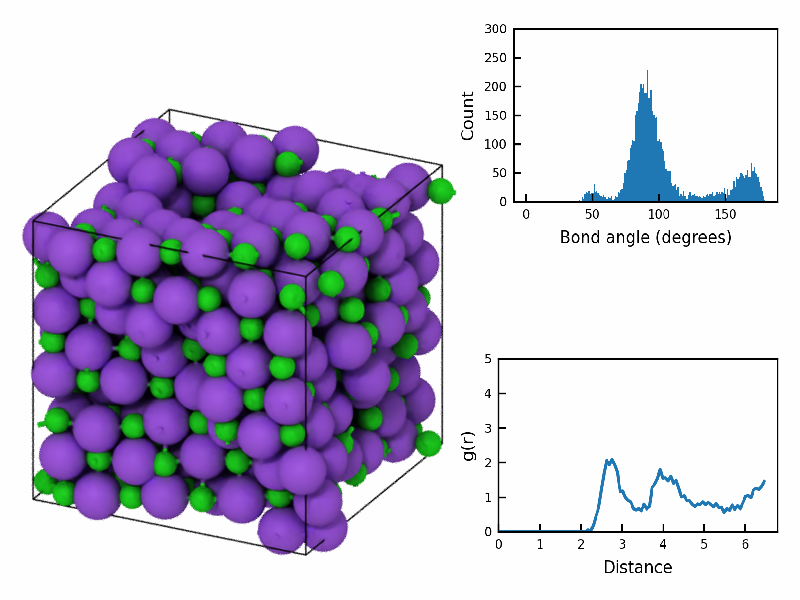

In [11]:
Image(open(fstatic, "rb").read())

In [12]:
fanim = "nacl_melt_animation.gif"
viewport.render_anim(
    size=(800, 600), every_nth=5, filename=fanim, renderer=OSPRayRenderer(), fps=10
)

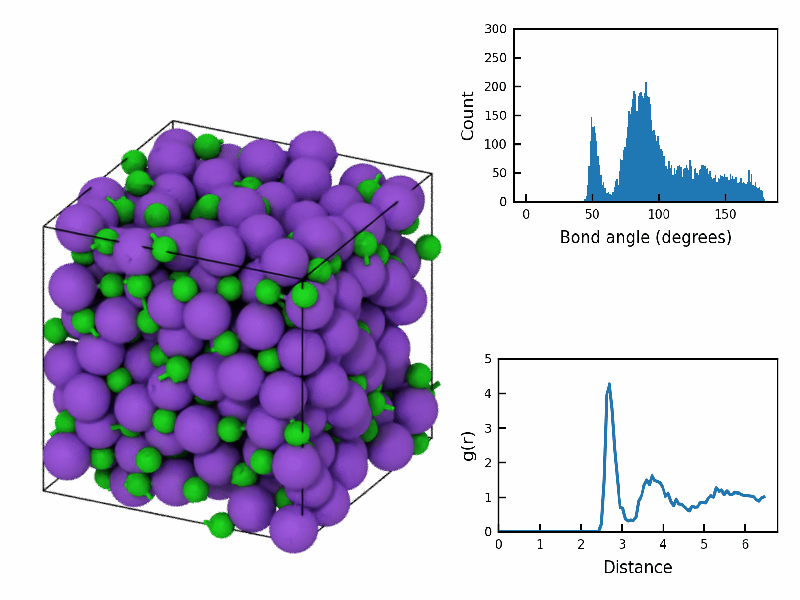

In [13]:
Image(open(fanim, "rb").read())